<a href="https://colab.research.google.com/github/vggls/M.Sc._AI_Thesis/blob/main/experiments/breakhis_resnet50/Attribution_Maps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Imports**

In [ ]:
pip install grad-cam

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 41.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.4.6-py3-none-any.whl size=38262 sha256=938850b491037b225336540bff8aa2083bf9fc238e4427097c2c7e0200d8f870
  Stored in directory: /root/.cache/pip/wheels/9b/ae/bd/221d138b169c4867b2ae5c893474d0b23bae6e4750bc95bc55
Successfully built grad-cam


In [ ]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import numpy as np
import shutil
import random

import torch
from torchvision  import datasets, transforms

from pytorch_grad_cam import GradCAM, HiResCAM

In [ ]:
# custom written code 
from breakhis_slide_allocation import allocate_slides_to_datasets
from breakhis_binary import create_datasets, summaries
from plot_tensor import convert_for_plot

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **2. Download from Kaggle**

In [ ]:
! mkdir ~/.kaggle/
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download ambarish/breakhis

100% 3.99G/3.99G [03:12<00:00, 24.0MB/s]
100% 3.99G/3.99G [03:12<00:00, 22.3MB/s]


In [ ]:
! unzip breakhis.zip

# **3. Create training, validation and test datasets**

In [ ]:
#shutil.rmtree('training_dataset')
#shutil.rmtree('validation_dataset')
#shutil.rmtree('test_dataset')

In [ ]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.2),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor([0.5, 0.5, 0.5]), torch.Tensor([0.5, 0.5, 0.5]))
])
# to be applied to validation and test data
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor([0.5, 0.5, 0.5]), torch.Tensor([0.5, 0.5, 0.5]))
])

In [ ]:
training_dataset, validation_dataset, test_dataset = create_datasets(train_transforms, test_transforms)

No benign slides overlap in training, validation and test sets!
No malignant slides overlap in training, validation and test sets!


In [ ]:
training_dataset.class_to_idx

{'benign': 0, 'malignant': 1}

In [ ]:
labels = training_dataset.class_to_idx
summaries(labels, True)

**As explained in the [Kaggle page](https://www.kaggle.com/datasets/ambarish/breakhis) the dataset consists of 2480 benign and 5429 malignant samples. As per above breakdown one can verify that the suggested data allocation (as per breakhis_slide_allocation.py and breakhis.py) preserves the number of samples.
This is also proven via the calcultion of section 4 (Class distribution).**


# **4. ResNet50**

In [ ]:
drive_path = './drive/MyDrive/Colab_Notebooks/dataset_models/BreakHis/Models/'
resnet50 = torch.load(drive_path + 'breakhis_resnet50.pt')
resnet50 = resnet50.eval()
resnet50 = resnet50.cuda()

In [ ]:
gradcam_instance = GradCAM(model=resnet50, target_layers=[resnet50.layer4[2].conv3], use_cuda=True)
hirescam_instance = HiResCAM(model=resnet50, target_layers=[resnet50.layer4[2].conv3], use_cuda=True)

In [ ]:
unfreeze = [resnet50.conv1, resnet50.bn1, resnet50.layer1, resnet50.layer2, resnet50.layer3, resnet50.layer4]
for child in unfreeze:
    for param in child.parameters():
        param.requires_grad = True

<ipython-input-32-33ab591ddbe5>:21: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.



<Figure size 432x288 with 0 Axes>

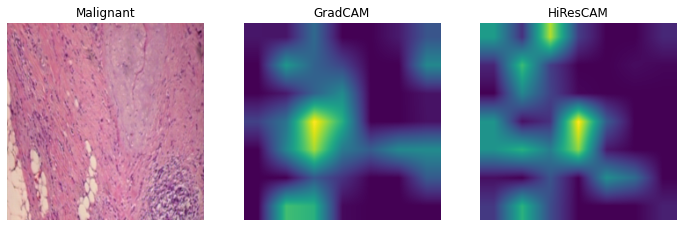

<Figure size 432x288 with 0 Axes>

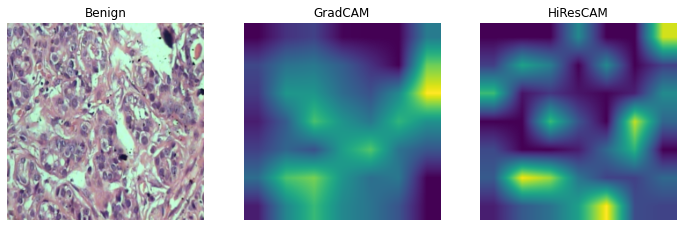

<Figure size 432x288 with 0 Axes>

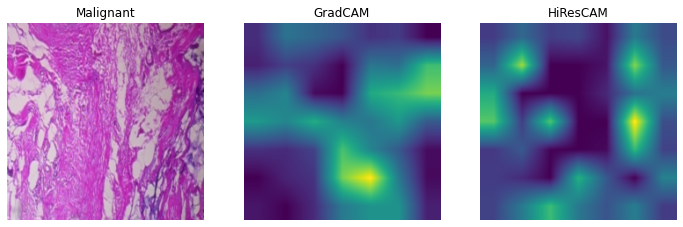

<Figure size 432x288 with 0 Axes>

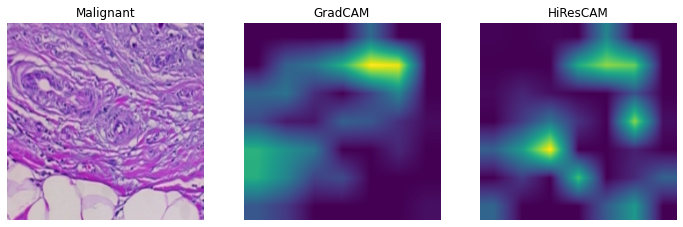

<Figure size 432x288 with 0 Axes>

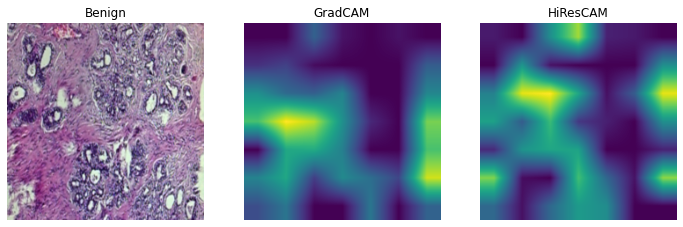

<Figure size 432x288 with 0 Axes>

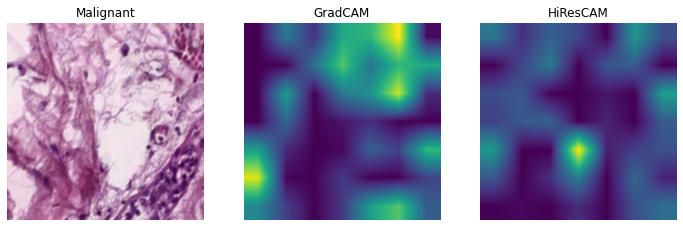

<Figure size 432x288 with 0 Axes>

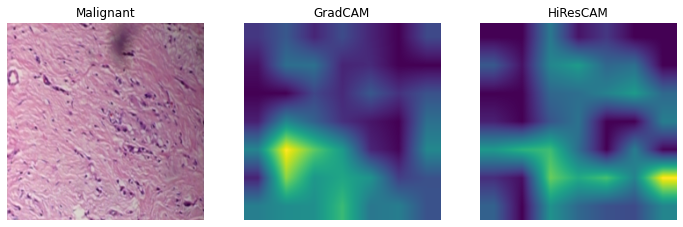

<Figure size 432x288 with 0 Axes>

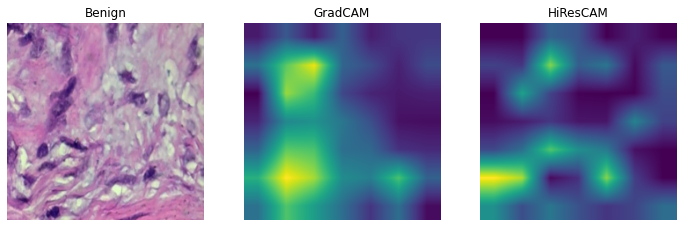

<Figure size 432x288 with 0 Axes>

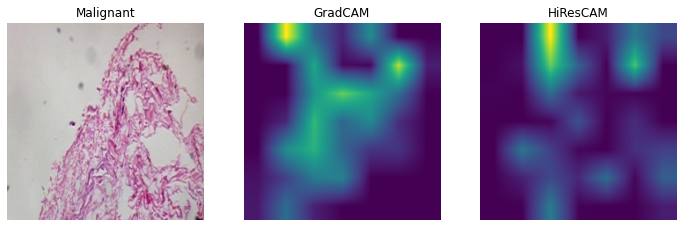

<Figure size 432x288 with 0 Axes>

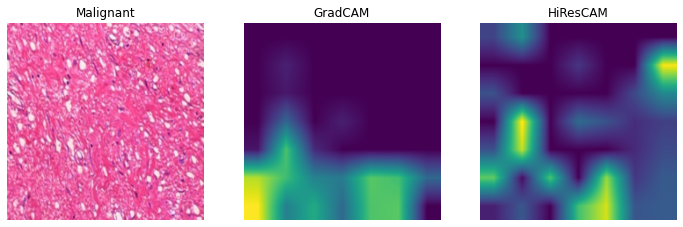

<Figure size 432x288 with 0 Axes>

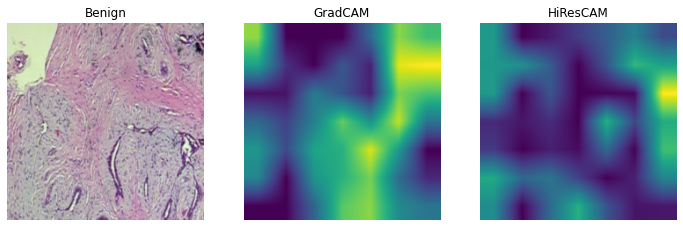

<Figure size 432x288 with 0 Axes>

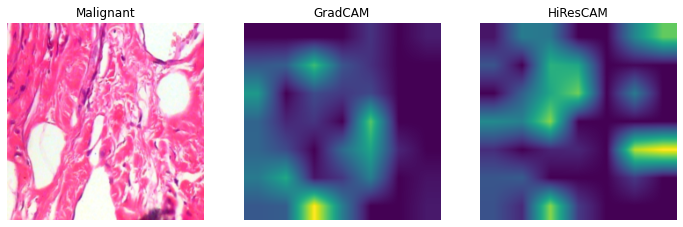

<Figure size 432x288 with 0 Axes>

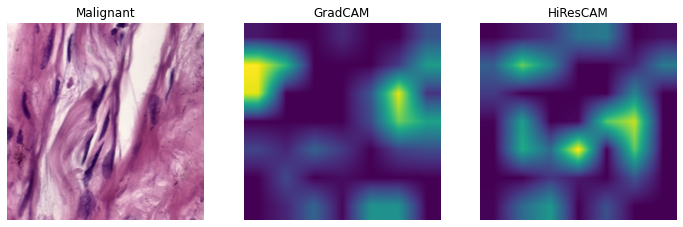

<Figure size 432x288 with 0 Axes>

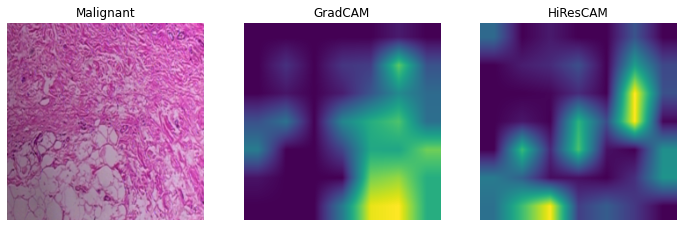

<Figure size 432x288 with 0 Axes>

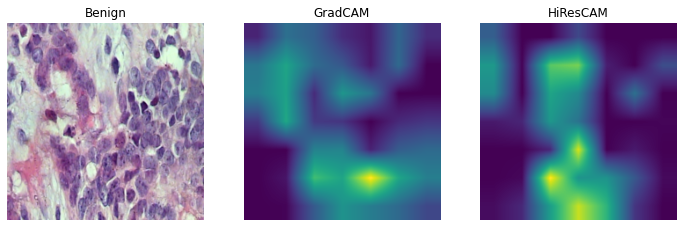

<Figure size 432x288 with 0 Axes>

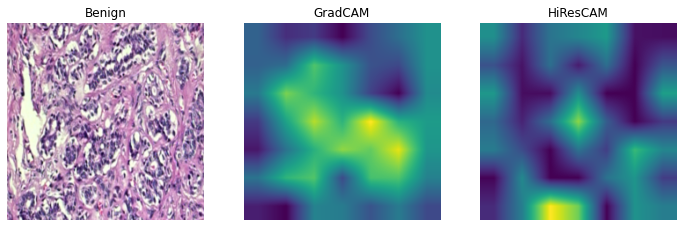

<Figure size 432x288 with 0 Axes>

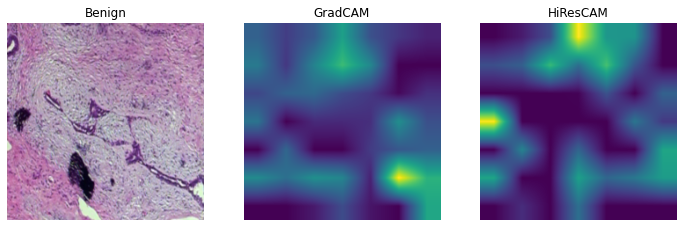

<Figure size 432x288 with 0 Axes>

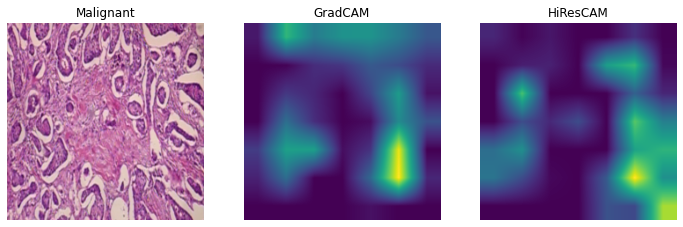

<Figure size 432x288 with 0 Axes>

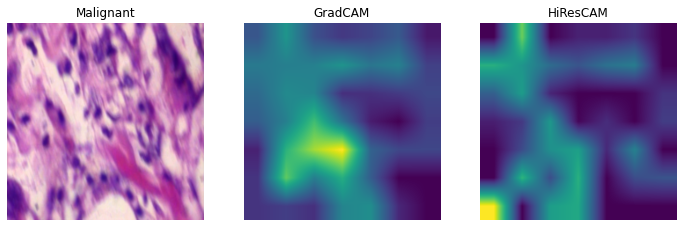

<Figure size 432x288 with 0 Axes>

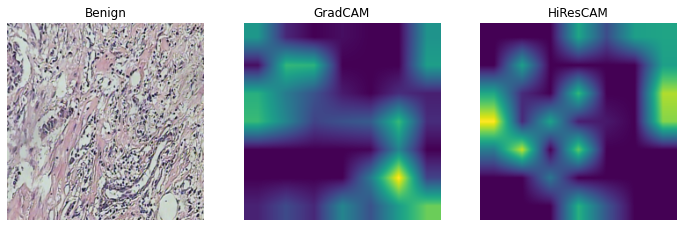

In [ ]:
i = 0

random_test_indices = random.sample(range(len(test_dataset)), 40)

classes = ['Benign', 'Malignant']

for index in random_test_indices:

    image, label = test_dataset[index]
    image = image.cuda()
    
    if label==int(torch.argmax(resnet50(image.unsqueeze(0)))): # use correctly classified decease images only
       
       i+=1
        
       clas = classes[label]
        
       gradcam_attributions = gradcam_instance(input_tensor=image.unsqueeze(0))[0,:,:]
       hirescam_attributions = hirescam_instance(input_tensor=image.unsqueeze(0))[0,:,:]
       
       plt.figure()
       fig, ax = plt.subplots(1, 3, figsize=(12,4))
       ax[0].imshow(convert_for_plot(image)); ax[0].set_title('{}'.format(clas)); ax[0].axis('off')
       ax[1].imshow(gradcam_attributions); ax[1].set_title('GradCAM'); ax[1].axis('off')
       ax[2].imshow(hirescam_attributions); ax[2].set_title('HiResCAM'); ax[2].axis('off')
       #fig.suptitle('write figure title here', fontsize=16)
        
    if i==20:
       break